In [64]:
import cv2
import numpy as np
import pandas as pd
import os
import argparse
import imutils
from scipy.spatial import distance as dist
import streamlit as st
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score 
import matplotlib.pyplot as plt 

LOADING WEIGHTS FOR SOCIAL DISTANCING


In [65]:
total_person=[]
number_of_people_violationg_socialdistancing=[]

In [66]:
model = "yolo-coco/yolov3.weights"
cfg = "yolo-coco/yolov3.cfg"
label_path= "yolo-coco/coco.names"
net = cv2.dnn.readNetFromDarknet(cfg,model)
labels= open(label_path).read().strip().split("\n")
ln= net.getLayerNames()
ln = ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

ENTERING THE PARAMETER

In [68]:
minimum_threshold=0.3
minimum_probability =0.3
minimum_distance = 50 
display = 1
output=""

TAKING THE INPUT

In [69]:
input_location = "pedestrians.mp4"
"""
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)"""

'\nnet.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)\nnet.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)'

FUNCTIONS TO IMPLEMENT WHETHER ITS A PEROSN OR NOT

In [70]:
def detect_people(frame, net, ln, personIdx=0):
    # grab the dimensions of the frame and  initialize the list of
    # results
    (H, W) = frame.shape[:2]
    results = []

    # construct a blob from the input frame and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes
    # and associated probabilities
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
        swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    # initialize our lists of detected bounding boxes, centroids, and
    # confidences, respectively
    boxes = []
    centroids = []
    confidences = []

    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability)
            # of the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter detections by (1) ensuring that the object
            # detected was a person and (2) that the minimum
            # confidence is met
            if classID == personIdx and confidence > 0.3:
                
                # scale the bounding box coordinates back relative to
                # the size of the image, keeping in mind that YOLO
                # actually returns the center (x, y)-coordinates of
                # the bounding box followed by the boxes' width and
                # height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top
                # and and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates,
                # centroids, and confidences
                boxes.append([x, y, int(width), int(height)])
                centroids.append((centerX, centerY))
                confidences.append(float(confidence))

    # apply non-maxima suppression to suppress weak, overlapping
    # bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.3)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # update our results list to consist of the person
            # prediction probability, bounding box coordinates,
            # and the centroid
            r = (confidences[i], (x, y, x + w, y + h), centroids[i])
            results.append(r)

    # return the list of results
    return results


INITIALIZING THE VIDEO STREAM

In [71]:
vs=cv2.VideoCapture(input_location if input_location else 0)
writer =None

In [72]:
while True:
    # read the next frame from the file
    (grabbed, frame) = vs.read()

    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break

    # resize the frame and then detect people (and only people) in it
    frame = imutils.resize(frame, width=700)
    results= detect_people(frame, net, ln,
        personIdx=labels.index("person"))

    # initialize the set of indexes that violate the minimum social
    # distance
    violate = set()
    

    # ensure there are *at least* two people detections (required in
    # order to compute our pairwise distance maps)
    if len(results) >= 2:
        # extract all centroids from the results and compute the
        # Euclidean distances between all pairs of the centroids
        centroids = np.array([r[2] for r in results])
        D = dist.cdist(centroids, centroids, metric="euclidean")

        # loop over the upper triangular of the distance matrix
        for i in range(0, D.shape[0]):
            for j in range(i + 1, D.shape[1]):
                # check to see if the distance between any two
                # centroid pairs is less than the configured number
                # of pixels
                if D[i, j] < minimum_distance  :
                    #number_of_people_violationg_socialdistancing=number_of_people_violationg_socialdistancing+1
                    # update our violation set with the indexes of
                    # the centroid pairs
                    violate.add(i)
                    violate.add(j)
    
    # loop over the results
    for (i, (prob, bbox, centroid)) in enumerate(results):
        # extract the bounding box and centroid coordinates, then
        # initialize the color of the annotation
        (startX, startY, endX, endY) = bbox
        (cX, cY) = centroid
        color = (0, 255, 0)

        # if the index pair exists within the violation set, then
        # update the color
        if i in violate:
            color = (0, 0, 255)
        number_of_people_violationg_socialdistancing.append(len(violate))
        total_person.append(len(results))

        # draw (1) a bounding box around the person and (2) the
        # centroid coordinates of the person,
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
        cv2.circle(frame, (cX, cY), 5, color, 1)

    # draw the total number of social distancing violations on the
    # output frame
    text = "Social Distancing Violations: {}".format(len(violate))
    cv2.putText(frame, text, (10, frame.shape[0] - 25),
        cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 3)

    # check to see if the output frame should be displayed to our
    # screen
    if display> 0:
        # show the output frame
        cv2.imshow("Frame",frame)
        key = cv2.waitKey(1) & 0xFF

        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            #number_of_people_violationg_socialdistancing=len(violate)
            break

    # if an output video file path has been supplied and the video
    # writer has not been initialized, do so now
    if output != "" and writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(args["output"], fourcc, 25000000,
            (frame.shape[1], frame.shape[0]), True)

    # if the video writer is not None, write the frame to the output
    # video file
    if writer is not None:
        writer.write(frame)
"""
while True:
    (grabbed,frame)=vs.read()
    frame = imutils.resize(frame,width=700)
    results =detect_person(frame, net, ln,minimum_threshold,minimum_probability,personIdx=labels.index("person"))
    violate = set()
    if len(results)>=2:
        centroids = np.array([r[2] for r in results])
        D = dist.cdist(centroids,centroids,metric="euclidean")
        for i in range(0,D.shape[0]):
            for j in range(i+1,D.shape[1]):
                if D[i,j]<minimum_distance:
                    violate.add(i)
                    violate.add(j)
    for (i,(prob,bbox,centroid)) in enumerate(results):
        (startX,startY,endX,endY)=bbox
        (cx,cy)=centroid
        color =(0,255,0)
        color_centre=(255,0,0)
        if i in violate:
            color =(0,0,255)
        cv2.rectangle(frame,(startX,startY),(endX,endY),color,2)
        cv2.circle(frame,(cx,cy),5,color_centre,1)
    text = "Social Distancing Violations: {}".format(len(violate))
    cv2.putText(frame, text, (10, frame.shape[0] - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 3)
    if display>0:
        cv2_imshow(frame)
        key = cv2.waitKey(1) & 0xFF
        if key==ord("q"):
            break
    if output!= "" and writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(args["output"], fourcc, 25,
            (frame.shape[1], frame.shape[0]), True)
    # if the video writer is not None, write the frame to the output
    # video file
    if writer is not None:
        writer.write(frame)
        """
        
            
         

'\nwhile True:\n    (grabbed,frame)=vs.read()\n    frame = imutils.resize(frame,width=700)\n    results =detect_person(frame, net, ln,minimum_threshold,minimum_probability,personIdx=labels.index("person"))\n    violate = set()\n    if len(results)>=2:\n        centroids = np.array([r[2] for r in results])\n        D = dist.cdist(centroids,centroids,metric="euclidean")\n        for i in range(0,D.shape[0]):\n            for j in range(i+1,D.shape[1]):\n                if D[i,j]<minimum_distance:\n                    violate.add(i)\n                    violate.add(j)\n    for (i,(prob,bbox,centroid)) in enumerate(results):\n        (startX,startY,endX,endY)=bbox\n        (cx,cy)=centroid\n        color =(0,255,0)\n        color_centre=(255,0,0)\n        if i in violate:\n            color =(0,0,255)\n        cv2.rectangle(frame,(startX,startY),(endX,endY),color,2)\n        cv2.circle(frame,(cx,cy),5,color_centre,1)\n    text = "Social Distancing Violations: {}".format(len(violate))\n    

In [44]:
print(len(number_of_people_violationg_socialdistancing))

687


In [45]:
print(len(total_person))
import seaborn as sns

687


No handles with labels found to put in legend.


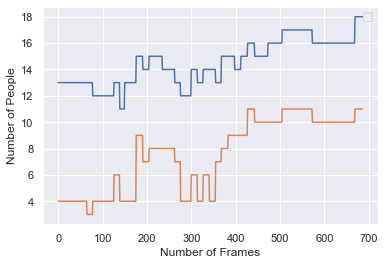

In [59]:
#sns.set_style("darkgrid")
x=total_person
plt.plot(x)
y=number_of_people_violationg_socialdistancing
plt.plot(y)
plt.xlabel('Number of Frames')
plt.ylabel('Number of People')
plt.legend()


In [77]:
%%writefile ml_server.py
import json
import numpy as np
import random 
from flask import Flask,request
import cv2
import pandas as pd
import os
import argparse
import imutils
from scipy.spatial import distance as dist
import streamlit as st
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score 
import matplotlib.pyplot as plt 

app = Flask(__name__)
model = "yolo-coco/yolov3.weights"
cfg = "yolo-coco/yolov3.cfg"
label_path= "yolo-coco/coco.names"
net = cv2.dnn.readNetFromDarknet(cfg,model)
labels= open(label_path).read().strip().split("\n")
ln= net.getLayerNames()
ln = ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
net = cv2.dnn.readNetFromDarknet(cfg,model)

minimum_threshold=0.3
minimum_probability =0.3
minimum_distance = 50 
display = 1
output=""

input_location = "pedestrians.mp4"

def detect_people(frame, net, ln, personIdx=0):
    # grab the dimensions of the frame and  initialize the list of
    # results
    (H, W) = frame.shape[:2]
    results = []

    # construct a blob from the input frame and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes
    # and associated probabilities
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
        swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    # initialize our lists of detected bounding boxes, centroids, and
    # confidences, respectively
    boxes = []
    centroids = []
    confidences = []

    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability)
            # of the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter detections by (1) ensuring that the object
            # detected was a person and (2) that the minimum
            # confidence is met
            if classID == personIdx and confidence > 0.3:
                
                # scale the bounding box coordinates back relative to
                # the size of the image, keeping in mind that YOLO
                # actually returns the center (x, y)-coordinates of
                # the bounding box followed by the boxes' width and
                # height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top
                # and and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates,
                # centroids, and confidences
                boxes.append([x, y, int(width), int(height)])
                centroids.append((centerX, centerY))
                confidences.append(float(confidence))

    # apply non-maxima suppression to suppress weak, overlapping
    # bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.3)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # update our results list to consist of the person
            # prediction probability, bounding box coordinates,
            # and the centroid
            r = (confidences[i], (x, y, x + w, y + h), centroids[i])
            results.append(r)

    # return the list of results
    return results

def final_pred():
    while True:
        # read the next frame from the file
        (grabbed, frame) = vs.read()

        # if the frame was not grabbed, then we have reached the end
        # of the stream
        if not grabbed:
            break

        # resize the frame and then detect people (and only people) in it
        frame = imutils.resize(frame, width=700)
        results= detect_people(frame, net, ln,
            personIdx=labels.index("person"))

        # initialize the set of indexes that violate the minimum social
        # distance
        violate = set()


        # ensure there are *at least* two people detections (required in
        # order to compute our pairwise distance maps)
        if len(results) >= 2:
            # extract all centroids from the results and compute the
            # Euclidean distances between all pairs of the centroids
            centroids = np.array([r[2] for r in results])
            D = dist.cdist(centroids, centroids, metric="euclidean")

            # loop over the upper triangular of the distance matrix
            for i in range(0, D.shape[0]):
                for j in range(i + 1, D.shape[1]):
                    # check to see if the distance between any two
                    # centroid pairs is less than the configured number
                    # of pixels
                    if D[i, j] < minimum_distance  :
                        #number_of_people_violationg_socialdistancing=number_of_people_violationg_socialdistancing+1
                        # update our violation set with the indexes of
                        # the centroid pairs
                        violate.add(i)
                        violate.add(j)

        # loop over the results
        for (i, (prob, bbox, centroid)) in enumerate(results):
            # extract the bounding box and centroid coordinates, then
            # initialize the color of the annotation
            (startX, startY, endX, endY) = bbox
            (cX, cY) = centroid
            color = (0, 255, 0)

            # if the index pair exists within the violation set, then
            # update the color
            if i in violate:
                color = (0, 0, 255)
            number_of_people_violationg_socialdistancing.append(len(violate))
            total_person.append(len(results))

            # draw (1) a bounding box around the person and (2) the
            # centroid coordinates of the person,
            cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
            cv2.circle(frame, (cX, cY), 5, color, 1)

        # draw the total number of social distancing violations on the
        # output frame
        text = "Social Distancing Violations: {}".format(len(violate))
        cv2.putText(frame, text, (10, frame.shape[0] - 25),
            cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 3)

        # check to see if the output frame should be displayed to our
        # screen
        if display> 0:
            # show the output frame
            cv2.imshow("Frame",frame)
            key = cv2.waitKey(1) & 0xFF

            # if the `q` key was pressed, break from the loop
            if key == ord("q"):
                #number_of_people_violationg_socialdistancing=len(violate)
                break

        # if an output video file path has been supplied and the video
        # writer has not been initialized, do so now
        if output != "" and writer is None:
            # initialize our video writer
            fourcc = cv2.VideoWriter_fourcc(*"MJPG")
            writer = cv2.VideoWriter(args["output"], fourcc, 25000000,
                (frame.shape[1], frame.shape[0]), True)

        # if the video writer is not None, write the frame to the output
        # video file
        if writer is not None:
            writer.write(frame)

        return total_person, number_of_people_violationg_socialdistancing




@app.route('/',methods=['GET','POST'])
def index():
    if request.method=='POST':
        total_person,number_of_people_violationg_socialdistancing= final_pred()
        return json.dumps({'TOTAL PERSON': total_person,'SOCIAL DISTANCE VIOLATIONS':number_of_people_violationg_socialdistancing})
    return 'Welcome'
if __name__=='__main__':
    app.run()

Overwriting ml_server.py


In [29]:
%%writefile app.py
import cv2
import streamlit as st
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import imutils
from scipy.spatial import distance as dist
def main():
    st.title("Social Distancing Anlyzer Web App")
    st.sidebar.title("Social Distancing Anlyzer Web App")
    st.markdown("Find total numberr of peoples who are following social-distancing ")
    st.sidebar.markdown("Find total numberr of peoples who are following social-distancing  ")
    filename = open('pedestrians.mp4','rb')
    video_bites = filename.read()
    st.sidebar.text("Input Video:")
    st.sidebar.video(video_bites)
    
    app_mode = st.sidebar.selectbox("Choose the app mode",
        ["About the App", "Run the app", "Show the source code"])
    if app_mode == "About the App":
        st.text('This is an app which detects whether the person is following social-distancing or not ')
        st.text('over an area with the help of CCTV footage or any video source and plots the data of same ')
    elif app_mode == "Show the source code":
        with st.echo():
            Link = "https://github.com/shreyanshsatvik/covid_tracer"
            
            
            
        
    elif app_mode == "Run the app":
        model = "yolo-coco/yolov3.weights"
        cfg = "yolo-coco/yolov3.cfg"
        label_path= "yolo-coco/coco.names"
        input_location = "pedestrians.mp4"
        net = cv2.dnn.readNetFromDarknet(cfg,model)
        labels= open(label_path).read().strip().split("\n")
        ln= net.getLayerNames()
        ln = ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
        minimum_threshold=0.3
        minimum_probability =0.3
        minimum_distance = 50 
        display = 1
        output=""
        total_person=[]
        number_of_people_violationg_socialdistancing=[]
        
        def detect_people(frame, net, ln, personIdx=0):
            # grab the dimensions of the frame and  initialize the list of
            # results
            (H, W) = frame.shape[:2]
            results = []

            # construct a blob from the input frame and then perform a forward
            # pass of the YOLO object detector, giving us our bounding boxes
            # and associated probabilities
            blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
                swapRB=True, crop=False)
            net.setInput(blob)
            layerOutputs = net.forward(ln)

            # initialize our lists of detected bounding boxes, centroids, and
            # confidences, respectively
            boxes = []
            centroids = []
            confidences = []

            # loop over each of the layer outputs
            for output in layerOutputs:
                # loop over each of the detections
                for detection in output:
                    # extract the class ID and confidence (i.e., probability)
                    # of the current object detection
                    scores = detection[5:]
                    classID = np.argmax(scores)
                    confidence = scores[classID]

                    # filter detections by (1) ensuring that the object
                    # detected was a person and (2) that the minimum
                    # confidence is met
                    if classID == personIdx and confidence > 0.3:

                        # scale the bounding box coordinates back relative to
                        # the size of the image, keeping in mind that YOLO
                        # actually returns the center (x, y)-coordinates of
                        # the bounding box followed by the boxes' width and
                        # height
                        box = detection[0:4] * np.array([W, H, W, H])
                        (centerX, centerY, width, height) = box.astype("int")

                        # use the center (x, y)-coordinates to derive the top
                        # and and left corner of the bounding box
                        x = int(centerX - (width / 2))
                        y = int(centerY - (height / 2))

                        # update our list of bounding box coordinates,
                        # centroids, and confidences
                        boxes.append([x, y, int(width), int(height)])
                        centroids.append((centerX, centerY))
                        confidences.append(float(confidence))

            # apply non-maxima suppression to suppress weak, overlapping
            # bounding boxes
            idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.3)

            # ensure at least one detection exists
            if len(idxs) > 0:
                # loop over the indexes we are keeping
                for i in idxs.flatten():
                    # extract the bounding box coordinates
                    (x, y) = (boxes[i][0], boxes[i][1])
                    (w, h) = (boxes[i][2], boxes[i][3])

                    # update our results list to consist of the person
                    # prediction probability, bounding box coordinates,
                    # and the centroid
                    r = (confidences[i], (x, y, x + w, y + h), centroids[i])
                    results.append(r)

            # return the list of results
            return results
        if st.button('Show Results in the video'):
            
            vs=cv2.VideoCapture(input_location if input_location else 0)
            writer =None
            while True:

                # read the next frame from the file
                (grabbed, frame) = vs.read()

                # if the frame was not grabbed, then we have reached the end
                # of the stream
                if not grabbed:
                    break

                # resize the frame and then detect people (and only people) in it
                frame = imutils.resize(frame, width=700)
                results= detect_people(frame, net, ln,
                    personIdx=labels.index("person"))

                # initialize the set of indexes that violate the minimum social
                # distance
                violate = set()


                # ensure there are *at least* two people detections (required in
                # order to compute our pairwise distance maps)
                if len(results) >= 2:
                    # extract all centroids from the results and compute the
                    # Euclidean distances between all pairs of the centroids
                    centroids = np.array([r[2] for r in results])
                    D = dist.cdist(centroids, centroids, metric="euclidean")

                    # loop over the upper triangular of the distance matrix
                    for i in range(0, D.shape[0]):
                        for j in range(i + 1, D.shape[1]):
                            # check to see if the distance between any two
                            # centroid pairs is less than the configured number
                            # of pixels
                            if D[i, j] < minimum_distance  :
                                #number_of_people_violationg_socialdistancing=number_of_people_violationg_socialdistancing+1
                                # update our violation set with the indexes of
                                # the centroid pairs
                                violate.add(i)
                                violate.add(j)

                # loop over the results
                for (i, (prob, bbox, centroid)) in enumerate(results):
                    # extract the bounding box and centroid coordinates, then
                    # initialize the color of the annotation
                    (startX, startY, endX, endY) = bbox
                    (cX, cY) = centroid
                    color = (0, 255, 0)

                    # if the index pair exists within the violation set, then
                    # update the color
                    if i in violate:
                        color = (0, 0, 255)
                    number_of_people_violationg_socialdistancing.append(len(violate))
                    total_person.append(len(results))

                    # draw (1) a bounding box around the person and (2) the
                    # centroid coordinates of the person,
                    cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
                    cv2.circle(frame, (cX, cY), 5, color, 1)

                # draw the total number of social distancing violations on the
                # output frame
                text = "Social Distancing Violations: {}".format(len(violate))
                cv2.putText(frame, text, (10, frame.shape[0] - 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 3)

                # check to see if the output frame should be displayed to our
                # screen
                if display> 0:
                    # show the output frame
                    cv2.imshow("Frame",frame)
                    key = cv2.waitKey(1) & 0xFF

                    # if the `q` key was pressed, break from the loop
                    if key == ord("q"):
                        filename1 = open('output.mp4','rb')
                        video_bites1 = filename1.read()
                        st.text("Output Video:")
                        st.video(video_bites1)
                        #number_of_people_violationg_socialdistancing=len(violate)
                        break
                        

                # if an output video file path has been supplied and the video
                # writer has not been initialized, do so now
                if output != "" and writer is None:
                    # initialize our video writer
                    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
                    writer = cv2.VideoWriter(args["output"], fourcc, 25000000,
                        (frame.shape[1], frame.shape[0]), True)

                # if the video writer is not None, write the frame to the output
                # video file
                if writer is not None:
                    writer.write(frame)
                    
            
            
            plt.plot(total_person)
            plt.plot(number_of_people_violationg_socialdistancing)
            plt.xlabel('Number of Frames')
            plt.ylabel('Number of People')
            st.pyplot()
            
            







        
        
        
        
        
        
        

if __name__ == "__main__":
    main()

    


Overwriting app.py


In [23]:
def model():
    abra=5
    dabra=10
    

In [110]:
model()

In [112]:
dabra

NameError: name 'dabra' is not defined

In [ ]:
"""
URI = ' http://127.0.0.1:5000/'


st.title("Social Distancing Anlyzer Web App")
st.sidebar.title("Social Distancing Anlyzer Web App")
st.markdown("Find total numberr of peoples who are following social-distancing ")
st.sidebar.markdown("Find total numberr of peoples who are following social-distancing  ")
filename = open('pedestrians.mp4','rb')
video_bites = filename.read()
st.sidebar.text("Input Video:")
st.sidebar.video(video_bites)
if st.button('Get Predictions'):
    response = requests.post(URI,data={})
    response = json.loads(response.text)
    Total_Person =respone.get('TOTAL PERSON')
    Violations = response.get('SOCIAL DISTANCE VIOLATIONS')
    
    st.dataframe(Total_person)
    
"""